# HMC

In [1]:
import jax 
import jax.numpy as jnp
from jax import jit, vmap
from jax import random
from src.models.vsh_model import*
from src.models.configuration import*
from src.data.data_utils import*
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist

/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:93: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:144: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:203: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/gaia_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = load_filtered_qso_df() # load filetered data
angles, obs, error = config_data(df)

In [3]:
def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)//2
    
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta_t = numpyro.sample("theta_t", dist.Uniform(-0.5, 0.5).expand([total_params]))
    theta_s = numpyro.sample("theta_s", dist.Uniform(-0.1, 0.1).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = least_square_hmc(angles, obs, error, theta_t, theta_s, lmax=lmax, grid=False)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)


In [4]:
kernel = NUTS(model_for_HMC, target_accept_prob=0.8)
rng_key = jax.random.key(0)
mcmc = MCMC(kernel, num_warmup=100, num_samples=2000, num_chains=4, progress_bar=True)
mcmc.run(rng_key, angles=angles, obs=obs, error=error, lmax=3)

posterior_sample = mcmc.get_samples()

/tmp/ipykernel_3381/2362444259.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=100, num_samples=2000, num_chains=4, progress_bar=True)
warmup:   2%|▏         | 41/2100 [01:42<1:25:52,  2.50s/it, 127 steps of size 1.45e-03. acc. prob=0.71]


KeyboardInterrupt: 

In [5]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 theta_s[0]     -0.01      0.00     -0.01     -0.01     -0.01   9381.55      1.00
 theta_s[1]      0.00      0.00      0.00     -0.00      0.00   5848.14      1.00
 theta_s[2]     -0.02      0.00     -0.02     -0.02     -0.01   9816.93      1.00
 theta_s[3]     -0.00      0.00     -0.00     -0.01     -0.00   3845.41      1.00
 theta_s[4]      0.01      0.00      0.01      0.01      0.01   8567.87      1.00
 theta_s[5]      0.01      0.00      0.01      0.01      0.01   8895.31      1.00
 theta_s[6]     -0.01      0.00     -0.01     -0.01     -0.01   9340.57      1.00
 theta_s[7]      0.01      0.00      0.01      0.00      0.01   7623.10      1.00
 theta_s[8]      0.00      0.00      0.00      0.00      0.00   6062.46      1.00
 theta_s[9]      0.00      0.00      0.00     -0.00      0.00   4559.99      1.00
theta_s[10]      0.00      0.00      0.00      0.00      0.01   8384.84      1.00
theta_s[11]    

In [6]:
s_lm = jnp.mean(posterior_sample['theta_s'], axis=0)
t_lm = jnp.mean(posterior_sample['theta_t'], axis=0)
std_s = jnp.std(posterior_sample['theta_s'], axis=0)
std_t = jnp.std(posterior_sample['theta_t'], axis=0)

In [7]:
spheroidal_vector_summary(s_lm, std_s**2, index = np.array([0,1,2]))

Equatorial components:
G_vec = [-0.45088786 -8.202835   -2.5381043 ] +/- [0.8384631  0.6853078  0.33379656](μas/yr)
Magnitude = 8.598358154296875 +/- 1.371079444885254 (μas/yr)
RA = 266.8537902832031 +/- 11.962297439575195 (deg)
Dec = -17.168615341186523 +/- 0.1920270472764969 (deg)

Galactic components:
G_vec = [8.41742678 1.53015725 0.85867355] +/- [0.62168318 0.57161122 0.75555141](μas/yr)
l = 10.302975325315133 +/- 3.83928927986359 (deg)
d = 5.731386556920483 +/- 0.40928258879805446 (deg)


In [8]:
toroidal_vector_summary(t_lm, std_t, index = np.array([0,1,2]))

R_vec = [ 5.5001535 -2.4638968 -0.7120509] +/- [17.297695 16.898705 10.669681](μas/yr)
Magnitude = 6.06873083114624 +/- 35.2105598449707 (μas/yr)
RA = 335.8691101074219 +/- 330.11083984375 (deg)
Dec = -6.738097667694092 +/- 35.832176208496094 (deg)


Try to extract covariance of VSH coefficients after determining posterior distribution

In [14]:
def cov_matrix_hmc(posterior_sample, indices=None):
    theta_samples = np.array(posterior_sample)
    cov_matrix = np.cov(theta_samples, rowvar=False)
    
    if indices is not None:
        cov_matrix = cov_matrix[np.ix_(indices, indices)]

    return cov_matrix


In [15]:
cov_slm = cov_matrix_hmc(posterior_sample["theta_s"], indices=[0,1,2])

In [16]:
correlation_slm = rho_matrix(cov_slm)
print(correlation_slm.shape)
print("Correlation matrix of spheroidal coefficients of VSH")
print(correlation_slm)
print('')
print("Example:")
print(f"rho(s11r,s11i) = {correlation_slm[0][1]}")

(3, 3)
Correlation matrix of spheroidal coefficients of VSH
[[ 1.         -0.02017899 -0.00758782]
 [-0.02017899  1.         -0.00990544]
 [-0.00758782 -0.00990544  1.        ]]

Example:
rho(s11r,s11i) = -0.020178985647500453


In [17]:
summary_equatorial, v_vec, Sigma_v = vsh_vector_summary(s_lm, cov_slm)

In [18]:
summary_equatorial

{'|g| (μas/yr)': np.float32(4.6404495),
 'g (μas/yr)': array([-1.4547749, -3.8274574, -2.1835685], dtype=float32),
 '|sigma_g| (μas/yr)': np.float64(0.5649745527185548),
 'sigma_g (μas/yr)': array([0.39173117, 0.66508133, 0.05693069]),
 'Corr_gx_gy': np.float64(0.020178985647500453),
 'Corr_gx_gz': np.float64(0.007587822208358225),
 'Corr_gy_gz': np.float64(-0.009905442567999235)}

In [19]:
alpha_delta_result = alpha_delta_summary(v_vec, Sigma_v)

In [20]:
alpha_delta_result

{'RA (deg)': np.float32(249.18875),
 'Sigma_RA (deg)': np.float64(3.9594852777931036),
 'Dec (deg)': np.float32(-28.070072),
 'Sigma_Dec (deg)': np.float64(3.9594852777931036),
 'Corr_RA_dec': np.float64(0.9721501459177418)}

### Using the same posterior

In [1]:
import jax 
import jax.numpy as jnp
from jax import jit, vmap
from jax import random
from src.models.vsh_model import*
from src.models.configuration import*
from src.data.data_utils import*
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import transforms

/root/Document/Gaia_Project/mem97/gaia_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = load_filtered_qso_df() # load filetered data
angles, obs, error = config_data(df)

### Using Uniform Distribution as Prior

In [3]:
def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Uniform(-.01, .01).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = least_square(angles, obs, error, theta, lmax=lmax, grid=False)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

HMC

In [4]:
kernel = NUTS(model_for_HMC, target_accept_prob=0.8)
rng_key = jax.random.key(2)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=4000, num_chains=4, progress_bar=True)
mcmc.run(rng_key, angles=angles, obs=obs, error=error, lmax=3)

posterior_sample = mcmc.get_samples()

/tmp/ipykernel_72639/3004625032.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=2000, num_samples=4000, num_chains=4, progress_bar=True)
sample: 100%|██████████| 6000/6000 [09:21<00:00, 10.69it/s, 15 steps of size 3.37e-01. acc. prob=0.87]


In [5]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.00      0.00      0.00     -0.00      0.00  16772.53      1.00
  theta[1]     -0.01      0.00     -0.01     -0.01     -0.01  12954.74      1.00
  theta[2]     -0.01      0.00     -0.01     -0.01     -0.01  19979.48      1.00
  theta[3]      0.01      0.00      0.01      0.00      0.01  13989.69      1.00
  theta[4]      0.00      0.00      0.00     -0.00      0.00  17737.43      1.00
  theta[5]     -0.01      0.00     -0.01     -0.01     -0.01  22802.07      1.00
  theta[6]      0.01      0.00      0.01      0.00      0.01  14197.97      1.00
  theta[7]     -0.00      0.00     -0.00     -0.01     -0.00  20349.52      1.00
  theta[8]      0.00      0.00      0.00      0.00      0.00  20885.68      1.00
  theta[9]      0.00      0.00      0.00     -0.00      0.00  19044.54      1.00
 theta[10]      0.01      0.00      0.01      0.01      0.01  14446.04      1.00
 theta[11]      0.01      0

In [6]:
coeff_est = jnp.mean(posterior_sample['theta'], axis = 0)
std_coeff = jnp.std(posterior_sample['theta'], axis = 0)
spheroidal_vector_summary(coeff_est, std_coeff**2)

Equatorial components:
G_vec = [-0.0735372 -4.778656  -2.6210475] +/- [0.7500972  0.10510066 0.31263444](μas/yr)
Magnitude = 5.450766086578369 +/- 0.47468411922454834 (μas/yr)
RA = 269.11834716796875 +/- 18.40250015258789 (deg)
Dec = -28.74148941040039 +/- 0.12587442994117737 (deg)

Galactic components:
G_vec = [ 5.44604547  0.13147654 -0.18481048] +/- [0.18166445 0.44055621 0.66658871](μas/yr)
l = 1.3829462149007756 +/- 4.632454657770069 (deg)
d = -1.9430095158481924 +/- 0.07513164544142618 (deg)


### Using Beta Distribution as Prior

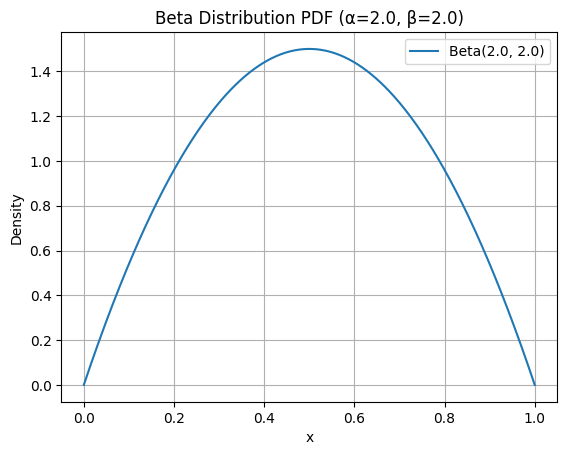

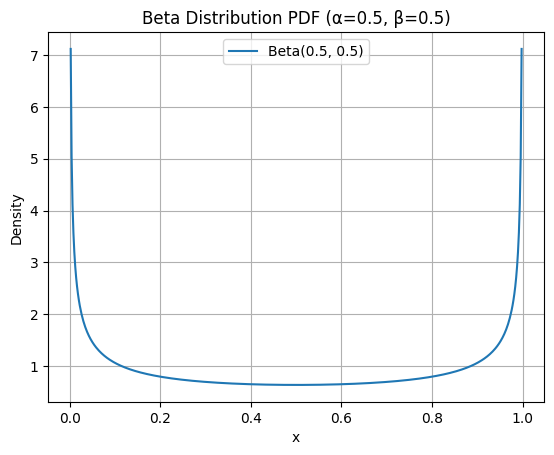

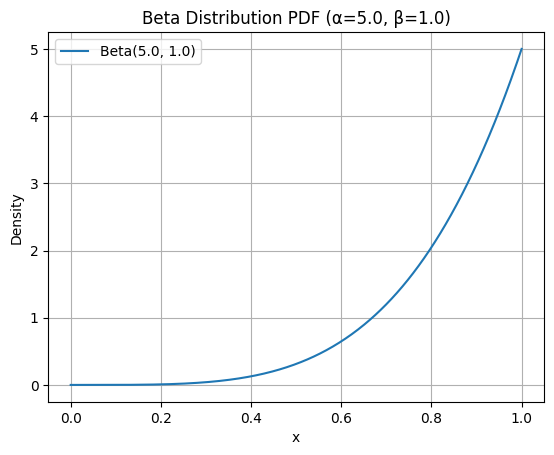

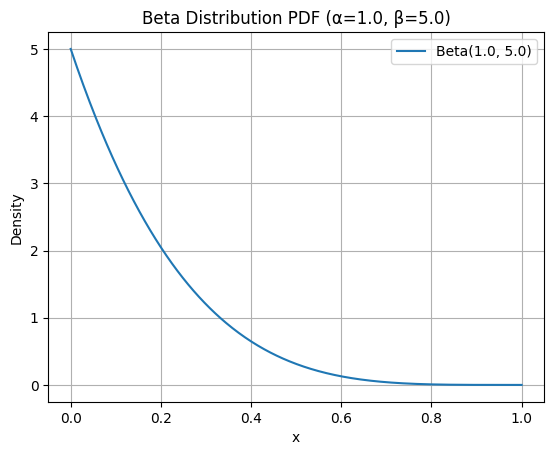

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def plot_beta_pdf(alpha, beta_param):
    x = np.linspace(0, 1, 500)
    y = beta.pdf(x, alpha, beta_param)

    plt.plot(x, y, label=f'Beta({alpha}, {beta_param})')
    plt.title(f'Beta Distribution PDF (α={alpha}, β={beta_param})')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
plot_beta_pdf(2.0, 2.0)     # symmetric bell-shaped
plot_beta_pdf(0.5, 0.5)     # U-shaped (peaked at 0 and 1)
plot_beta_pdf(5.0, 1.0)     # skewed toward 1
plot_beta_pdf(1.0, 5.0)     # skewed toward 0


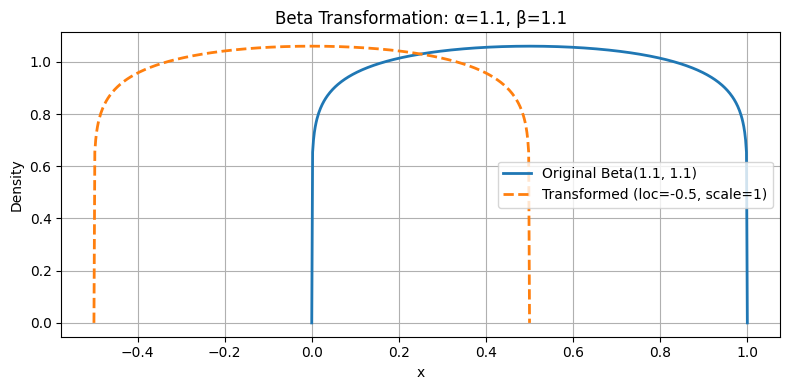

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def plot_beta_transformation(alpha, beta_param, loc, scale):
    # Original Beta support and PDF
    x_base = np.linspace(0, 1, 500)
    y_base = beta.pdf(x_base, alpha, beta_param)
    
    # Transformed x and corresponding PDF
    x_transformed = loc + scale * x_base
    y_transformed = y_base / scale  # Adjust for scaling in PDF

    # Plot both
    plt.figure(figsize=(8, 4))
    plt.plot(x_base, y_base, label=f'Original Beta({alpha}, {beta_param})', lw=2)
    plt.plot(x_transformed, y_transformed, label=f'Transformed (loc={loc}, scale={scale})', lw=2, linestyle='--')
    plt.title(f'Beta Transformation: α={alpha}, β={beta_param}')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: try changing these!
plot_beta_transformation(alpha=1.1, beta_param=1.1, loc=-0.5, scale=1)


In [43]:
def model_for_HMC_beta(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    
    # Transform Beta distribution so that is shifted to -0.1, 0.1
    base_beta = dist.Beta(1.1, 1.1).expand([total_params]) 
    transform = transforms.AffineTransform(loc = -0.5, scale = 1.0)
    dist_transformed = dist.TransformedDistribution(base_beta, transform)

    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist_transformed)

    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = least_square(angles, obs, error, theta, lmax=lmax, grid=False)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

In [1]:
kernel = NUTS(model_for_HMC_beta, target_accept_prob=0.75)
rng_key = jax.random.key(0)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=4000, num_chains=4, progress_bar=True)
mcmc.run(rng_key, angles=angles, obs=obs, error=error, lmax=3)

posterior_sample = mcmc.get_samples()
mcmc.print_summary()

NameError: name 'NUTS' is not defined

In [10]:
key = random.PRNGKey(0)
total_params = count_vsh_coeffs(3)
base_beta = dist.Beta(2.0, 2.0).expand([total_params])
transform = transforms.AffineTransform(loc=-0.01, scale=0.02)
dist_theta = dist.TransformedDistribution(base_beta, transform)

theta_sample = dist_theta.sample(key)
print("theta sample:", theta_sample)
print("log prob:", dist_theta.log_prob(theta_sample))
print("chi2:", least_square(angles, obs, error, theta_sample, lmax=3, grid=False))

theta sample: [-0.00050796 -0.00557542  0.00197793  0.00527503  0.00455874 -0.00095241
 -0.00534815  0.00173164  0.00540995 -0.00212678 -0.00390879 -0.00181791
 -0.00646534 -0.00370775 -0.00694041  0.00054907  0.00160707 -0.00348521
  0.00012103  0.00272355  0.001309    0.00403111  0.00040125  0.00121859
 -0.00180473 -0.006192   -0.00619681 -0.00710045 -0.00393487  0.00237242]
log prob: [4.314905  3.9451883 4.277581  3.991399  4.0845213 4.308377  3.9805794
 4.2870445 3.9712229 4.271202  4.1516867 4.2838826 3.776194  4.1695986
 3.6603017 4.31447   4.291323  4.1879873 4.3173428 4.2404165 4.3002057
 4.1401567 4.315878  4.302528  4.2843766 3.8339396 3.8329728 3.6159797
 4.149269  4.2595596]
chi2: 2664979.5


In [11]:
coeff_est = jnp.mean(posterior_sample['theta'], axis = 0)
std_coeff = jnp.std(posterior_sample['theta'], axis = 0)
spheroidal_vector_summary(coeff_est, std_coeff**2)

Equatorial components:
G_vec = [-0.14678285 -8.535842   -2.655623  ] +/- [0.74277544 0.6461233  0.31809944](μas/yr)
Magnitude = 8.940608024597168 +/- 1.2920430898666382 (μas/yr)
RA = 269.01483154296875 +/- 10.202303886413574 (deg)
Dec = -17.279264450073242 +/- 0.06920184195041656 (deg)

Galactic components:
G_vec = [8.74845955 1.7407656  0.6071862 ] +/- [0.58637677 0.52322657 0.67288498](μas/yr)
l = 11.253709350328286 +/- 3.3771915150178 (deg)
d = 3.8941427616587885 +/- 0.2532217157986921 (deg)


# Data Filtering with HMC

- Before filtering the data, we should see how the model behaves with different priors, (Unifrom and Normal)
- In particular we want to focus on the Uniform prior, what happens if we provide different limits

In [2]:
import jax 
import jax.numpy as jnp
from jax import jit, vmap
from src.models.vsh_model import*
from jax import random
import pandas as pd
import gc
from src.models.configuration import*
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist
from src.data.data_utils import*
from numpyro.diagnostics import summary


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import corner

In [4]:
def corner_plot(posterior_sample, index = [1, 4, 5]):

    samples_array = np.column_stack([posterior_sample['theta'][:, param] for param in index])

    figure = corner.corner(samples_array,
                           labels = [r"$s_{10}$", r"$s_{11}^{R}$", r"$s_{11}^i$"],
                           quantiles=[0.15, 0.5, 0.85], 
                           show_titles=True,
                           title_kwargs={"fontsize":14},
                           label_kwargs={"fontsize":14},
                           bins=30,
                           smooth=1)
    plt.show()

In [5]:
df = load_qso_dataframe() # load full dataset for 5 param solution
angles, obs, error = config_data(df)

In [6]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])


def model_w_uni_prior(angles, obs, error, limit = 0.1, lmax = 3):
    total_params = count_vsh_coeffs(lmax)
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Uniform(-limit, limit).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

def model_w_norm_prior(angles, obs, error, std = 0.1, lmax = 3):

    total_params = count_vsh_coeffs(lmax)
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Normal(0., std).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)


n_s = 100 # number of samples
n_warmup = 100 #  number of warmups 
n_chains = 2 # numbe of chains

In [15]:
x = np.random.randint(1, 101)
rng_key = jax.random.key(x)

kernel_uni = NUTS(model_w_uni_prior, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%
mcmc_uni = MCMC(kernel_uni, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
mcmc_uni.run(rng_key, angles = angles, obs = obs, error = error, limit = 1, lmax=3)
ps_w_uni_prior = mcmc_uni.get_samples()
diagnostics = summary(mcmc_uni.get_samples(group_by_chain=True))
divergences = mcmc_uni.get_extra_fields()["diverging"]  # shape: (num_samples * num_chains,)
num_divergences = divergences.sum()
print("Number of divergences:", num_divergences)
del mcmc_uni
gc.collect()
jax.clear_caches()

/tmp/ipykernel_30121/3383952141.py:5: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_uni = MCMC(kernel_uni, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
sample: 100%|██████████| 200/200 [00:29<00:00,  6.77it/s, 15 steps of size 2.72e-02. acc. prob=0.93]


Number of divergences: 0


In [13]:
diagnostics

{'theta': OrderedDict([('mean',
               array([-0.0001653 , -0.00830086, -0.01144619,  0.00723681,  0.00095835,
                      -0.01688663,  0.00457614, -0.00443573,  0.00279317,  0.00178176,
                       0.00838586,  0.01104916, -0.00205698,  0.00596633, -0.00972823,
                       0.00493084,  0.00404426,  0.00307545, -0.00863843,  0.00510377,
                       0.00205723,  0.00282255, -0.0052332 , -0.00895081,  0.00473627,
                      -0.00272278,  0.00608273, -0.01069304,  0.00379148, -0.00419803],
                     dtype=float32)),
              ('std',
               array([0.00106792, 0.00110606, 0.0013743 , 0.00113456, 0.00144511,
                      0.00133005, 0.00087396, 0.00098314, 0.00141829, 0.00150617,
                      0.00142046, 0.00132511, 0.0011698 , 0.00136025, 0.00153794,
                      0.00140396, 0.00088736, 0.00088288, 0.00140914, 0.00129281,
                      0.00109964, 0.00130639, 0.00147649,

In [12]:
diagnostics['theta']['r_hat']

array([0.99542975, 0.9959547 , 0.9950167 , 0.99544245, 1.0013052 ,
       1.0059804 , 1.0084474 , 1.0084364 , 0.99284506, 1.0107272 ,
       0.9962355 , 1.003772  , 1.0037185 , 0.99588114, 0.99185246,
       1.0175898 , 1.0100518 , 0.9995577 , 1.003647  , 1.0057514 ,
       0.99058944, 0.9970582 , 1.0003084 , 0.99708843, 0.99253774,
       0.9966121 , 0.9937246 , 0.99896777, 1.0061713 , 0.99755913],
      dtype=float32)

In [13]:
x = np.random.randint(1, 101)
rng_key = jax.random.key(x)

kernel_norm = NUTS(model_w_norm_prior, target_accept_prob=0.75)
mcmc_norm = MCMC(kernel_norm, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
mcmc_norm.run(rng_key, angles = angles, obs = obs, error = error, std = 1, lmax=3)

ps_w_norm_prior = mcmc_norm.get_samples()

mcmc_norm.print_summary()
del mcmc_norm
gc.collect()
jax.clear_caches()

/tmp/ipykernel_14821/787664747.py:5: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_norm = MCMC(kernel_norm, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
sample: 100%|██████████| 200/200 [00:26<00:00,  7.68it/s, 15 steps of size 3.30e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]     -0.00      0.00     -0.00     -0.00      0.00    275.59      0.99
  theta[1]     -0.01      0.00     -0.01     -0.01     -0.01    181.47      0.99
  theta[2]     -0.01      0.00     -0.01     -0.01     -0.01    365.02      0.99
  theta[3]      0.01      0.00      0.01      0.01      0.01    302.67      0.99
  theta[4]      0.00      0.00      0.00     -0.00      0.00    174.52      0.99
  theta[5]     -0.02      0.00     -0.02     -0.02     -0.01    190.25      1.02
  theta[6]      0.00      0.00      0.00      0.00      0.01    144.31      1.00
  theta[7]     -0.00      0.00     -0.00     -0.01     -0.00    365.06      1.00
  theta[8]      0.00      0.00      0.00      0.00      0.01    400.85      1.00
  theta[9]      0.00      0.00      0.00     -0.00      0.00    254.75      1.01
 theta[10]      0.01      0.00      0.01      0.01      0.01    435.93      0.99
 theta[11]      0.01      0

In [14]:
coeff_est_uni = jnp.mean(ps_w_uni_prior['theta'], axis = 0)
std_coeff_uni = jnp.std(ps_w_uni_prior['theta'], axis = 0)
spheroidal_vector_summary(coeff_est_uni, std_coeff_uni**2)

Equatorial components:
G_vec = [-0.46825087 -8.250848   -2.8678977 ] +/- [0.70431685 0.64823705 0.38118172](μas/yr)
Magnitude = 8.747604370117188 +/- 1.3048875331878662 (μas/yr)
RA = 266.7518615722656 +/- 9.991519927978516 (deg)
Dec = -19.13829803466797 +/- 0.18424025177955627 (deg)

Galactic components:
G_vec = [8.61988107 1.29658557 0.73286852] +/- [0.59672764 0.53416653 0.64819381](μas/yr)
l = 8.554188728115552 +/- 3.5206894232953654 (deg)
d = 4.805835653008141 +/- 0.3259017078443417 (deg)


In [17]:
coeff_est_uni.shape

(30,)

In [14]:
coeff_est_norm = jnp.mean(ps_w_norm_prior['theta'], axis = 0)
std_coeff_norm = jnp.std(ps_w_norm_prior['theta'], axis = 0)
spheroidal_vector_summary(coeff_est_norm, std_coeff_norm**2)

Equatorial components:
G_vec = [-0.45222813 -8.168141   -2.8822913 ] +/- [0.6433198  0.5705418  0.30382162](μas/yr)
Magnitude = 8.67356014251709 +/- 1.1398929357528687 (μas/yr)
RA = 266.8310546875 +/- 9.218585968017578 (deg)
Dec = -19.408905029296875 +/- 0.1659420281648636 (deg)

Galactic components:
G_vec = [8.55372736 1.25696067 0.69602077] +/- [0.5207593  0.46578849 0.58612001](μas/yr)
l = 8.35972017777663 +/- 3.095003273902038 (deg)
d = 4.602721077306404 +/- 0.2751470750573477 (deg)


With Uniform Prior:


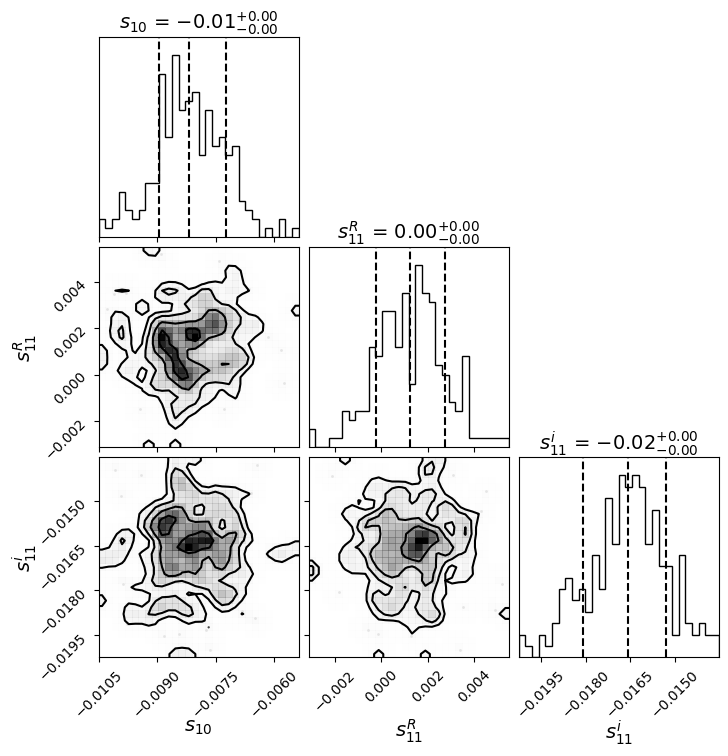

With Normal Prior


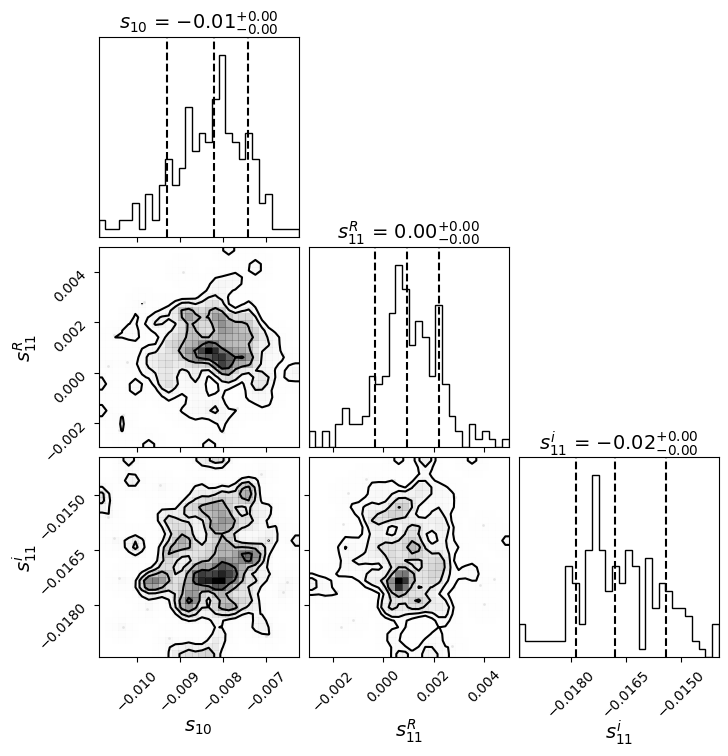

In [15]:
print('With Uniform Prior:')
corner_plot(ps_w_uni_prior)
print('With Normal Prior')
corner_plot(ps_w_norm_prior)

## Filtering data using HMC

In [1]:
import jax 
import jax.numpy as jnp
from jax import jit, vmap
from src.models.vsh_model import*
from jax import random
import pandas as pd
import gc
from src.models.configuration import*
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist
from src.data.data_utils import*
from numpyro.diagnostics import summary


/root/Document/Gaia_Project/mem97/gaia_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = load_qso_dataframe() # load full dataset for 5 param solution
angles, obs, error = config_data(df)

In [ ]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])


def model_w_uni_prior(angles, obs, error, 
                      limit = 0.1, lmax = 3):
    total_params = count_vsh_coeffs(lmax)
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Uniform(-limit, limit).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)


def filter_data_hmc(angles, obs, error, lmax = 3, 
                    kappa=3.0, max_iter=10,
                    kernel = NUTS(model_w_uni_prior, target_accept_prob=0.75),
                    limit=0.1, rng_key = jax.random.key(0),
                    n_s = 2000,
                    n_warmup = 500,
                    n_chains = 3):

    alpha, delta = angles
    mu_a_obs, mu_d_obs = obs
    s_mu_a, s_mu_d, rho = error

    keep = jnp.ones_like(alpha, dtype=bool)

    prev_outliers = None

    for iteration in range(max_iter):
        print('Iteration:',iteration+1)
        alpha_k, delta_k = alpha[keep], delta[keep]
        obs_k = (mu_a_obs[keep], mu_d_obs[keep])
        err_k = (s_mu_a[keep], s_mu_d[keep], rho[keep])
        angles_k = (alpha_k, delta_k)

        kernel_uni = kernel # this is to make sure acceptance does not exceed 90%
        mcmc_uni = MCMC(kernel_uni, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
        mcmc_uni.run(rng_key, angles = angles_k, obs = obs_k, error = err_k, limit = limit, lmax=3)
        ps_w_uni_prior = mcmc_uni.get_samples()

        diagnostics = summary(mcmc_uni.get_samples(group_by_chain=True))
        r_hats = diagnostics['theta']['r_hat']
        avg_r_hat = np.sum(r_hats) / len(r_hats)
        print("Average r_hat:", avg_r_hat)

        divergences = mcmc_uni.get_extra_fields()["diverging"]  # shape: (num_samples * num_chains,)
        num_divergences = divergences.sum()
        print("Number of divergences:", num_divergences)

        del mcmc_uni
        gc.collect()
        jax.clear_caches()

        theta = jnp.mean(ps_w_uni_prior['theta'], axis=0)
        C0 = 1000/np.sqrt(8*np.pi/3)
        C1 = 1000/np.sqrt(4*np.pi/3)

        print(f'Current g components [μas/yr]: gx = {-theta[4]*C1}, gy = {theta[5]*C1}, gz = {theta[1]*C0}')

        # Compute X^2 over full dataset (not just kept subset)
        X = np.sqrt(compute_X2(alpha, delta, mu_a_obs, mu_d_obs, s_mu_a, s_mu_d, rho, theta, lmax))
        median_X = jnp.median(X)
        keep = X < kappa*median_X

        print(f"Rejected: {(~keep).sum()} sources")

        if prev_outliers is not None and jnp.array_equal(keep, prev_outliers):
            print(f"Converged after {iteration+1} iterations.")
            break
        prev_outliers = keep

    return theta, keep


In [4]:
theta, keep = filter_data_hmc(angles, obs, error, limit=1.)

Iteration: 1


/tmp/ipykernel_38483/2257173171.py:42: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_uni = MCMC(kernel_uni, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
sample: 100%|██████████| 2500/2500 [02:50<00:00, 14.67it/s, 7 steps of size 1.99e-01. acc. prob=0.87] 


Average r_hat: 0.9998203
Number of divergences: 0
Current g components [μas/yr]: gx = -0.5322785973548889, gy = -8.172586441040039, gz = -2.8459861278533936
Iteration: 2


  0%|          | 0/2500 [00:00<?, ?it/s]2025-05-22 20:22:45.163475: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %sine.1215 = f32[1212158]{0} sine(%constant.11304), metadata={op_name="jit(_body_fn)/jit(main)/while/body/while/body/jvp(jit(chi2_jit))/jit(least_square)/vmap(jit(model_vsh))/jit(T_lm)/jit(T_lm_scalar)/jvp(jit(Y_lm))/exp" source_file="/root/Document/Gaia_Project/mem97/src/models/vsh_model.py" source_line=196}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-05-22 20:22:45.163807: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.413555224

Average r_hat: 0.999818
Number of divergences: 0
Current g components [μas/yr]: gx = -0.137787327170372, gy = -8.597023963928223, gz = -2.647125244140625
Iteration: 3


sample: 100%|██████████| 2500/2500 [02:29<00:00, 16.70it/s, 7 steps of size 2.25e-01. acc. prob=0.83] 


Average r_hat: 0.99993485
Number of divergences: 0
Current g components [μas/yr]: gx = -0.13934297859668732, gy = -8.608956336975098, gz = -2.6401138305664062
Iteration: 4


sample: 100%|██████████| 2500/2500 [02:28<00:00, 16.78it/s, 7 steps of size 2.38e-01. acc. prob=0.81] 


Average r_hat: 0.9998702
Number of divergences: 0
Current g components [μas/yr]: gx = -0.12422610074281693, gy = -8.599457740783691, gz = -2.642979621887207
Iteration: 5


sample: 100%|██████████| 2500/2500 [02:30<00:00, 16.60it/s, 7 steps of size 2.25e-01. acc. prob=0.83] 


Average r_hat: 0.99993485
Number of divergences: 0
Current g components [μas/yr]: gx = -0.13934297859668732, gy = -8.608956336975098, gz = -2.6401138305664062
Iteration: 6


sample:  37%|███▋      | 933/2500 [01:39<02:47,  9.34it/s, 7 steps of size 2.23e-01. acc. prob=0.83]   


KeyboardInterrupt: 

In [6]:
theta

Array([ 0.00027102, -0.00764444, -0.0108088 ,  0.00701752,  0.0002696 ,
       -0.01761511,  0.00428951, -0.0044594 ,  0.00293229,  0.00147377,
        0.0084215 ,  0.0108992 , -0.00212199,  0.00557706, -0.0102203 ,
        0.00499635,  0.00367804,  0.00288024, -0.00846351,  0.00535877,
        0.00217564,  0.00265336, -0.00550778, -0.00880698,  0.00439126,
       -0.00307463,  0.00599899, -0.01067113,  0.00402155, -0.00393636],      dtype=float32)

In [7]:
df_clean = df.loc[np.array(keep)]
angles_clean, obs_clean, error_clean = config_data(df_clean)
print(f'Number of data points excluded : {len(angles[0]) - len(angles_clean[0])}')

Number of data points excluded : 3783


In [7]:
C0 = np.sqrt(8*np.pi/3)
C1 = np.sqrt(4*np.pi/3)

print(theta[1]/C0*1000)
print(-theta[4]/C1*1000)
print(theta[5]/C1*1000)

-2.6411085
-0.13172616
-8.606785
